In [ ]:
# Problem 1: Transfer Learning
# 1. Choose a pre-trained deep learning model that has been trained to classify images.
# 2. Use the German Traffic Sign Dataset below (that the pre-trained model in (1) wasn't trained on) to define a new "traffic sign" classification problem.
# 3. Use transfer learning to adapt the pre-trained model in (1) to your new image classification problem in (2).
# 4. Is your new model able to classify test images from (2) with high accuracy? 

In [ ]:
import os
import numpy as np
import time
import cv2

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from sklearn.metrics import accuracy_score

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    return images

In [ ]:
IMAGE_SHAPE = (128, 128)
batch_size = 32
model_path ="https://tfhub.dev/google/bit/m-r101x3/ilsvrc2012_classification/1"

In [ ]:
classes = pd.read_csv("archive/Meta.csv")["ClassId"].unique()
test_labels = pd.read_csv("archive/Test.csv")["ClassId"]

In [ ]:
tfhub_cache_dir = os.path.join(os.getcwd(),'tfhub_cache')
os.makedirs(tfhub_cache_dir, exist_ok = True)
os.environ['TFHUB_CACHE_DIR'] = tfhub_cache_dir

### Dataset Config

In [ ]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()

data_directory = './archive'

for i in range(classes):
    path = os.path.join(data_directory, 'Train', str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            image = image.resize((30, 30))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

data = np.array(data)
labels = np.array(labels)

In [ ]:
#Splitting training and testing dataset

X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [ ]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

X_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.batch(batch_size).prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)

### Model Building and Traning

In [ ]:
# get the classifier without head
classifier = hub.KerasLayer(
    model_path, input_shape=(30,30, 3), trainable=False)

In [ ]:
classifier.trainable = False  # Freeze the outer model

In [ ]:
num_classes = 43

model = tf.keras.Sequential([
  classifier,
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              387934888 
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 43)                43043     
                                                                 
Total params: 387,981,931
Trainable params: 45,043
Non-trainable params: 387,936,888
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['acc'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.01,
    patience=5)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping], batch_size=batch_size)

Epoch 1/50
981/981 [==============================] - 188s 172ms/step - loss: 1.7311 - acc: 0.4751 - val_loss: 1.4066 - val_acc: 0.5570
Epoch 2/50
981/981 [==============================] - 164s 167ms/step - loss: 1.2698 - acc: 0.5893 - val_loss: 1.2769 - val_acc: 0.5940
Epoch 3/50
981/981 [==============================] - 164s 167ms/step - loss: 1.1314 - acc: 0.6296 - val_loss: 1.2151 - val_acc: 0.6093
Epoch 4/50
981/981 [==============================] - 164s 167ms/step - loss: 1.0462 - acc: 0.6574 - val_loss: 1.1778 - val_acc: 0.6246
Epoch 5/50
981/981 [==============================] - 164s 167ms/step - loss: 0.9847 - acc: 0.6760 - val_loss: 1.1533 - val_acc: 0.6320
Epoch 6/50
981/981 [==============================] - 163s 167ms/step - loss: 0.9368 - acc: 0.6911 - val_loss: 1.1362 - val_acc: 0.6400
Epoch 7/50
981/981 [==============================] - 165s 168ms/step - loss: 0.8976 - acc: 0.7036 - val_loss: 1.1240 - val_acc: 0.6450
Epoch 8/50
981/981 [============================

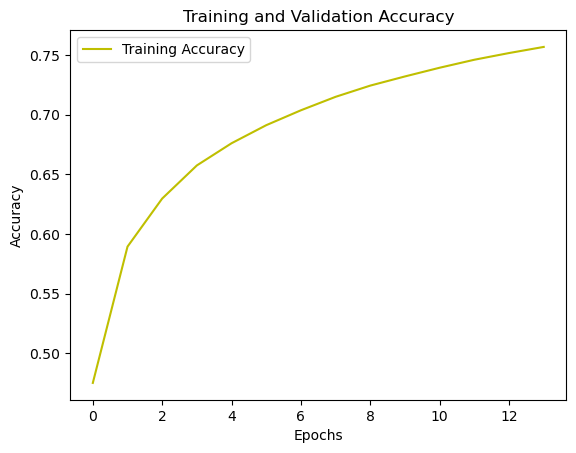

In [ ]:
accuracy  = history.history["acc"]
#val_accuracy  = history["val_accuracy"]
epochs = len(accuracy)


plt.plot(history.epoch, accuracy, 'y', label='Training Accuracy')
#plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

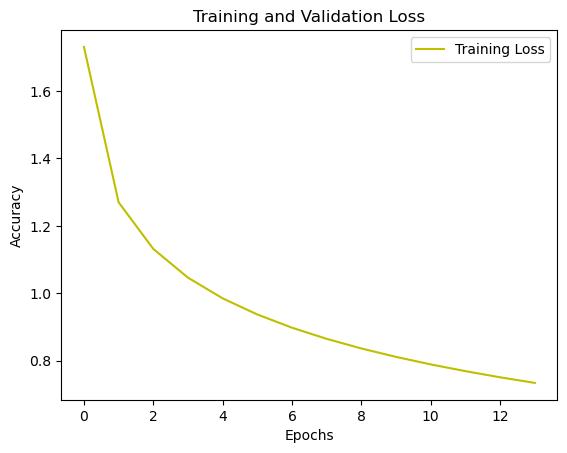

In [ ]:
loss  = history.history['loss']
#val_loss = history.history['val_loss']

plt.plot(history.epoch, loss, 'y', label='Training Loss')
#plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
test_data = pd.read_csv("./archive/Test.csv")
labels = test_data["ClassId"].values
filenames = test_data["Path"].values

data2 = []

for filename in filenames:
    img_path = os.path.join("./archive", filename)
    image = Image.open(img_path)
    image = image.resize((30,30))
    data2.append(np.array(image))

In [ ]:
X_test = np.array(data2)

pred_probs = model.predict(X_test)

pred = np.argmax(pred_probs, axis=1)

acc = accuracy_score(labels, pred)
acc

395/395 [==============================] - 46s 112ms/step


0.45027711797307995

In [ ]:
pred_df = pd.DataFrame(pred)
pred_df.to_csv("preds.csv")

### Check Predictions

In [ ]:
#plt.figure(figsize=(10,9))
#plt.subplots_adjust(hspace=0.5)
#for n in range(15):
#  plt.subplot(6,5, n+1)
#  plt.imshow(test_ds[n])
#  plt.imshow()
#  plt.axis('off')
#_ = plt.suptitle("Model predictions")

### Save Model

In [ ]:
export_path = os.path.join(os.getcwd(),'saved_models','model')
model.save(export_path)

INFO:tensorflow:Assets written to: c:\Users\isacs\source\repos\Embedded_A1\Assigment 2\saved_models\model\assets


INFO:tensorflow:Assets written to: c:\Users\isacs\source\repos\Embedded_A1\Assigment 2\saved_models\model\assets
